In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from CallOption import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 512 # number of trajectories (batch size)
N = 200  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1.0] * D)[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
model = CallOption(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10 ** 4
lr = 1e-3

In [4]:
n_iter = 31 * 10 ** 2
lr = 1e-5

In [5]:
model.load_model("models/CallOption4-256XVAPaper.pth")

In [6]:
np.random.seed(37)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(15):
    t_test_i, W_test_i = model.fetch_minibatch()
    X_pred_i, Y_pred_i = model.predict(Xi, t_test_i, W_test_i)
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    if type(t_test_i).__module__ != 'numpy':
        t_test_i = t_test_i.cpu().numpy()
    t_test = np.concatenate((t_test, t_test_i), axis=0)
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)

In [7]:
Y_pred[:,0,:]

array([[0.10392755],
       [0.10392755],
       [0.10392755],
       ...,
       [0.10392755],
       [0.10392755],
       [0.10392755]], dtype=float32)

In [8]:
X_pred = X_pred[:500,:]

In [9]:
from scipy.stats import multivariate_normal as normal

In [10]:
X_preds = X_pred[:,:,0]

In [11]:
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * normal.cdf(d1)) - (K * np.exp(-r * T) * normal.cdf(d2))
    return call_price

def calculate_option_prices(X_pred, time_array, K, r, sigma, T, q=0):
    rows, cols = X_pred.shape
    option_prices = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            S = X_pred[i, j]
            t = time_array[j]
            time_to_maturity = T - t
            if time_to_maturity > 0: 
                option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)
            else:
                option_prices[i, j] = max(S - K, 0) 
    
    return option_prices


# Given parameters
K = 1.0     # Strike price
r = 0.01   # Risk-free interest rate
sigma = 0.25  # Volatility
q = 0      # Dividend yield (assuming none)
T = 1      # Expiry time in years

Y_test = calculate_option_prices(X_preds, t_test[0], K, r, sigma, T, q)

/tmp/ipykernel_1186582/4115188484.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)


In [12]:
errors = (Y_test[:500] - Y_pred[:500,:,0])**2
errors.mean(), errors.std()

(2.848881086653312e-05, 5.5648627214787343e-05)

In [13]:
np.sqrt(errors.mean())

0.0053374910647731415

In [14]:
graph = model.iteration, model.training_loss

In [15]:
def figsize(scale, nplots = 1):
    fig_width_pt = 438.17227                        
    inches_per_pt = 1.0/72.27                       
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            
    fig_width = fig_width_pt*inches_per_pt*scale    
    fig_height = nplots*fig_width*golden_mean             
    fig_size = [fig_width,fig_height]
    return fig_size

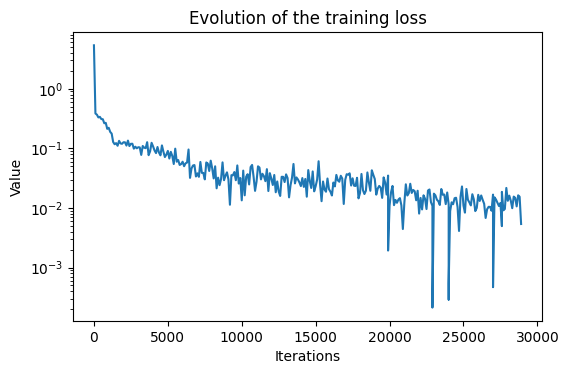

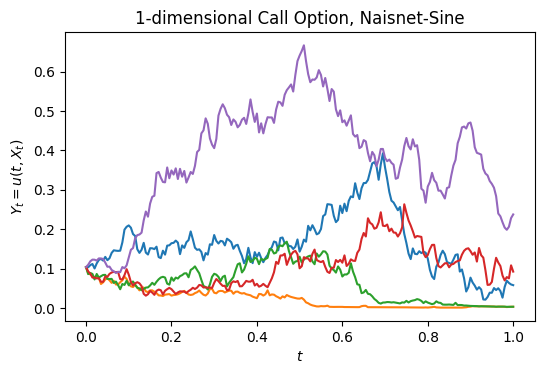

In [16]:
plt.figure(figsize=figsize(1.0))
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
samples = 5
plt.savefig('Figures/CallOption1DLoss.pdf')
plt.figure(figsize=figsize(1.0))
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T)

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Call Option, ' + model.mode + "-" + model.activation)

plt.show()

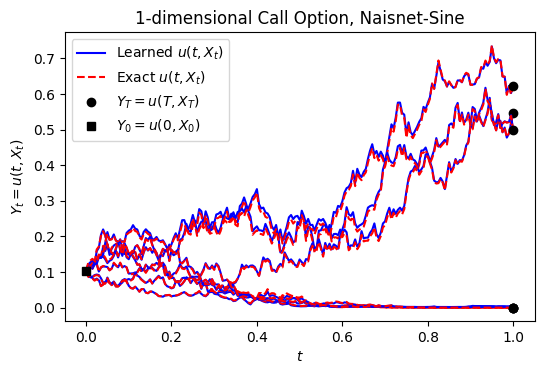

In [18]:
plt.figure(figsize=figsize(1.0))
plt.plot(t_test[1], Y_pred[1], 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[1], Y_test[1], 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[1, -1], Y_test[1, -1], 'ko', label='$Y_T = u(T,X_T)$')
for i in [23,24,34,35,43,73]:
    plt.plot(t_test[i], Y_pred[i], 'b')
    plt.plot(t_test[i], Y_test[i], 'r--')
    plt.plot(t_test[i, -1], Y_test[i, -1], 'ko')
plt.plot([0], Y_test[0,0], 'ks', label='$Y_0 = u(0,X_0)$')
plt.title(str(D) + '-dimensional Call Option, ' + model.mode + "-" + model.activation)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.savefig("Figures/CallOption1DPreds.pdf")
plt.show()

In [19]:
Y_pred.shape

(8192, 201, 1)

In [20]:
r = 0.01

In [21]:
Y_preds = Y_pred.reshape(8192,201)

In [22]:
time_stamps = t_test[0].reshape(201,)
time_stamps

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

In [23]:
epe = np.mean(np.exp(-r*time_stamps) * np.maximum(Y_preds,0),axis=0) * 100  
epe

array([10.39291  , 10.397259 , 10.397088 , 10.408346 , 10.3966875,
       10.417242 , 10.416365 , 10.42973  , 10.427555 , 10.418065 ,
       10.419284 , 10.410044 , 10.404129 , 10.398431 , 10.399534 ,
       10.41059  , 10.420682 , 10.409476 , 10.420002 , 10.4249525,
       10.41306  , 10.438115 , 10.450012 , 10.456295 , 10.465417 ,
       10.461454 , 10.464727 , 10.454208 , 10.462501 , 10.448849 ,
       10.457913 , 10.477629 , 10.469265 , 10.478672 , 10.48577  ,
       10.469376 , 10.466521 , 10.455453 , 10.446203 , 10.446214 ,
       10.458409 , 10.473859 , 10.464446 , 10.464993 , 10.484152 ,
       10.493069 , 10.491203 , 10.486142 , 10.47492  , 10.486157 ,
       10.476182 , 10.480083 , 10.478381 , 10.477436 , 10.4803295,
       10.4861965, 10.468618 , 10.461925 , 10.462911 , 10.472616 ,
       10.46761  , 10.469547 , 10.45974  , 10.461872 , 10.461414 ,
       10.470945 , 10.474626 , 10.481805 , 10.513709 , 10.5164385,
       10.505249 , 10.510735 , 10.496168 , 10.4867115, 10.4760

In [24]:
ene = np.mean(np.minimum(Y_preds,0),axis=0) * 100
ene

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [25]:
s=100.0 # spot price
k=100.0 # strike price
r=0.01 # risk-free rate
sigma=0.25 # volatility
T=1 # time to maturity

d1 = (np.log(s/k) + (r + 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))
d2 = (np.log(s/k) + (r - 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))

call = (s * normal.cdf(d1, 0.0, 1.0) - k * np.exp(-r * (T - 0) ) * normal.cdf(d2, 0.0, 1.0))

In [26]:
call

10.403539152996629

In [27]:
epe_exact = np.array([call for s in time_stamps[1:]])
ene_exact = np.array([0.0 for s in time_stamps[1:]])

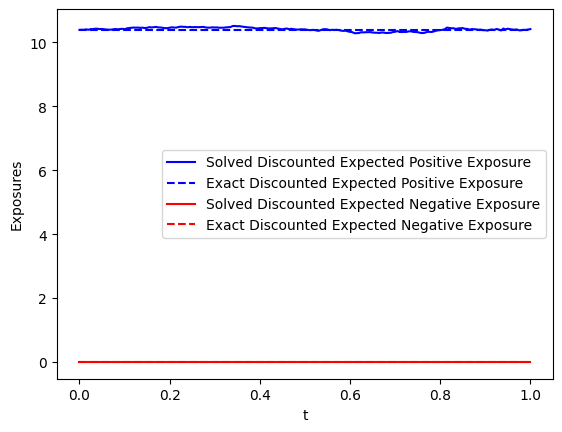

In [28]:
fig = plt.figure()
plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )
plt.plot(time_stamps,[call] + list(epe_exact),'b--',label='Exact Discounted Expected Positive Exposure')
plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')
plt.plot(time_stamps,[0.0]+list(ene_exact),'r--',label='Exact Discounted Expected Negative Exposure')

plt.xlabel('t')
plt.ylabel('Exposures')
plt.legend()
plt.savefig('Figures/CallOption1DExposures.pdf')
plt.show()

In [29]:
np.max(np.abs(np.insert(epe_exact,0,call) - epe)), np.max(np.abs(np.insert(ene_exact,0,0) - ene))

(0.11470648850688292, 0.0)

In [31]:
np.std(np.abs(np.insert(epe_exact,0,call) - epe)), np.std(np.abs(np.insert(ene_exact,0,0) - ene))

(0.03281282590514587, 0.0)

In [34]:
np.sqrt(np.mean((np.insert(epe_exact,0,call) - epe)**2 / np.insert(epe_exact,0,call) ** 2))

0.005425753280397713

In [35]:
var = np.abs(np.quantile((Y_preds - Y_preds[:,0][:,None]), 0.05, axis=0))

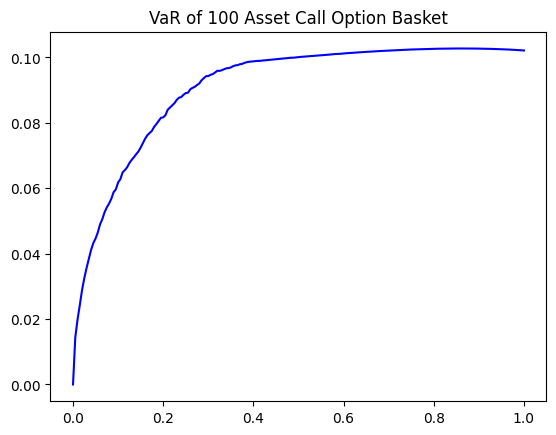

In [36]:
plt.title('VaR of 100 Asset Call Option Basket')
plt.plot(time_stamps,var,'b',label='VaR')
plt.show()

In [37]:
model.save_model("models/CallOption4-256XVAPaper.pth")